In [1]:
#double notebook inline needed because of matplotlib bug
%matplotlib notebook
%matplotlib notebook
#import relevant libraries
import numpy as np
import scipy.stats as sts
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import colors
import heapq
import random
from matplotlib.animation import PillowWriter

# Model

In [2]:
class Cell(object):
    """
    Cell Object to represent every grid in our Cellular Automaton
    Params:
        x: x-cooridinate of cell
        y: y-coordinate of cell
        wall, person, exit: type boolean to represent type of cell
    
    """
    def __init__(self,x,y,wall,person,exit):
        #coordinates of cell
        self.x=x
        self.y=y
        
        #wall/exit/person
        self.wall=wall
        self.exit=exit
        self.person=person
        
        #pathfinder variables
        self.g = 0.0 #cost from the start to this cell
        self.f = 0.0 #distance from start to this point
        self.opened = 0
        self.closed = False
        self.parent= None
    
    def __lt__(self, other):
        #efficient sorting by f value
        return self.f < other.f
        
    def remove_person(self):
        #removes person from cell
        self.person=False
        
    def add_person(self):
        #adds person to cell
        self.person=True
    
    def clean(self):
        #clean method for initialising pathfinder variables
        self.g = 0.0 #cost from the start to this cell
        self.f = 0.0 #distance from start to this point
        
        self.opened = 0
        self.closed = False
        
        self.parent= None
        
        

In [3]:
class Grid(object):
    """
    Grid object: to represent room layout
    params:
        matrix: type array with encoding:
                0 - free space
                1 - wall
                2 - exit
                3 - person
    """
    def __init__(self,matrix):
        self.matrix=matrix
        cells=[]
        rows,columns=matrix.shape
        #interpret matrix based on encoding
        for x in range(rows):
            cells.append([])
            for y in range(columns):
                wall= True if matrix[x][y]== 1 else False
                exit= True if matrix[x][y]== 2 else False
                person= True if matrix[x][y]== 3 else False

                cells[x].append(Cell(x,y,wall,person,exit))
        self.cells=cells
        
    def display(self):
        #display method
        plt.figure(figsize=(12,12))
        plt.imshow(self.matrix)
        
    def update_matrix(self):
        #update matrix attribute for display
        rows,columns=self.matrix.shape
        matrix=np.zeros((rows,columns))
        for x in range(rows):
            for y in range(columns):
                if self.cell(x,y).person:
                    matrix[x][y]= 3
                elif self.cell(x,y).exit:
                    matrix[x][y]= 2
                elif self.cell(x,y).wall:
                    matrix[x][y]= 1
        self.matrix=matrix
    
    def clean(self):
        #call on Cell.clean method
        for x in self.cells:
            for cell in x:
                cell.clean()                
        
    def inside(self,x,y):
        #establishes whether coordinates are inside
        x_bound=0<=x<self.matrix.shape[0]
        y_bound=0<=y<self.matrix.shape[1]
        return x_bound and y_bound
        
    def cell(self,x,y):
        #get node at position x,y
        return self.cells[x][y]
    
    def is_walkable(self,x,y):
        #establishes whether cell is walkable (free from wall or people)
        if self.inside(x,y) and not self.cells[x][y].wall and not self.cells[x][y].person:
                return True
        else:
                return False
    
    def neighbors(self, cell):
        #get all neighbors of a cell
        x=cell.x
        y=cell.y
        neighbors=[]
        
        #find all potential neighbors        
        #up
        if self.is_walkable(x-1,y):
            neighbors.append(self.cells[x-1][y])

        #down    
        if self.is_walkable(x+1,y):
            neighbors.append(self.cells[x+1][y])

        #left
        if self.is_walkable(x,y-1):
            neighbors.append(self.cells[x][y-1])

        #right
        if self.is_walkable(x,y+1):
            neighbors.append(self.cells[x][y+1])
    
        #up-left
        if self.is_walkable(x-1,y-1):
            neighbors.append(self.cells[x-1][y-1])

        #up-right    
        if self.is_walkable(x-1,y+1):
            neighbors.append(self.cells[x-1][y+1])

        #down-left
        if self.is_walkable(x+1,y-1):
            neighbors.append(self.cells[x+1][y-1])
            
        #down-right
        if self.is_walkable(x+1,y+1):
            neighbors.append(self.cells[x+1][y+1])
            
        return neighbors 

In [22]:
class Finder(object):
    """
    Finder Object for Dijkstra's Algorithm
    params:
        grid: type Grid
        start: type Cell
        end: type Cell
    """
    def __init__(self,grid,start,end):
        self.grid=grid
        self.start=start
        self.end=end
        
    def cost(self,cell1,cell2):
        #cost calculator
        if cell2.x-cell1.x == 0 or cell2.y-cell1.y == 0:
            #straight
            g=1
        else:
            #diagonal
            g=2**0.5
        return cell1.g+g
    
    def find_neighbors(self, cell):
        #call on Grid.neighbors method
        return self.grid.neighbors(cell)
    
    def process_cell(self,cell,parent,end,open_list):   
        #process cell, based on current path list        
        # calculate cost from current node (parent) to the next node (neighbor)
        ng = self.cost(parent, cell)

        if not cell.opened or ng < cell.g:
            cell.g = ng
            # f is the estimated total cost from start to goal
            cell.f = cell.g
            cell.parent = parent

            if not cell.opened:
                heapq.heappush(open_list, cell)
                cell.opened=True
            else:
                # the node can be reached with smaller cost.
                # Since its f value has been updated, we have to
                # update its position in the open list
                open_list.remove(cell)
                heapq.heappush(open_list, cell)
    
    def find_path(self):
        #Dijkstra's Algorithm
        start=self.start
        end=self.end
        start.opened=True
        
        open_list=[start]
        current_cell=start
        counter=0
        while current_cell != end:
            counter+=1
            if counter>100000:
                path=[]
                length=np.inf
                self.grid.clean()
                return path, length
            if len(open_list)<1:
                current_cell==end
            else:
                current_cell=heapq.nsmallest(1,open_list)[0]
                open_list.remove(current_cell)
                current_cell.closed=True
                neighbors = self.find_neighbors(current_cell)
                for neighbor in neighbors:
                    if neighbor.closed:
                        continue
                    self.process_cell(neighbor,current_cell,end,open_list)
        
        path=self.back_trace(current_cell.x,current_cell.y)
        length=current_cell.f
        self.grid.clean()
        return path,length
                
        
    def back_trace(self,x,y):
        #backtrace to retrieve path for Dijkstra's Algorithm
        cell=self.grid.cell(x,y)
        path=[(cell.x,cell.y)]
        counter=0
        while cell.parent:
            counter+=1
            if counter>1000:
                print("back trace error")
                break
            cell =cell.parent
            path.append((cell.x,cell.y))
        path.reverse()
        return path
    
    

In [23]:
 class Simulation(object):
    """
    Simulation Class: Incorporate all previous classes
    params: 
        matrix: type array 
    """
    def __init__(self, matrix):
        self.grid=Grid(matrix)
        self.n_people=len(self.people())
        self.storage=[]
        self.time=0
        self.moves=0
    
    def people(self):
        #return list of Cell objects of people
        people=[]
        for x in self.grid.cells:
            for y in x:
                if y.person:
                    people.append(y)
        return people
    
    def exits(self):
        #return list of Cell objects for exits
        exits=[]
        for x in self.grid.cells:
            for y in x:
                if y.exit:
                    exits.append(y)
        return exits
    
    def nearest_exit(self,person,exits):
        #Call on Finder to find path
        best_exit_dist=np.inf
        best_path=0
        for i in exits:
            dijkstra=Finder(self.grid,person,i)
            path=dijkstra.find_path()
            if path[1]<best_exit_dist:
                best_exit_dist=path[1]
                best_path=path[0]
                
        return best_path
    
    def move_person(self,person,exit_path):
        #move person to next step on path
        path=exit_path
        if isinstance(path,list): 
            next_cell=self.grid.cell(path[1][0],path[1][1])
            next_cell.add_person()
            person.remove_person()
            self.moves+=1
        else:
            next_cell=person
            
        if next_cell.exit:
            #print('removed')
            next_cell.remove_person()
            self.n_people-=1
    
    def extract_matrix(self):
        #extract matrix for animation
        self.storage.append(self.grid.matrix)
        
    def step(self,people,exits):
        #single step of simulation
        self.time+=1
        random.shuffle(people)
        for person in people:
            #print("person",person.x,person.y)
            best_exit=self.nearest_exit(person,exits)
            #print("best exit",best_exit[-1])
            self.move_person(person,best_exit)


        
        
    def simulate(self):
        #Main simulation method
        exits=self.exits()
       
        while self.n_people>0:
            #print("number of people:",self.n_people)
            people=self.people()
            self.step(people,exits)
            self.grid.update_matrix()
            self.extract_matrix()


In [8]:
class LoopingPillowWriter(PillowWriter):
    """
    Animation class for GIF export

    """
    def finish(self):
        self._frames[0].save(
            self._outfile, save_all=True, append_images=self._frames[1:],
            duration=int(1000 / self.fps), loop=0)
        
def animate(matrices,interval):
    #animate function
    fig = plt.figure()

    ims=[]
    cmap=colors.ListedColormap(['white','grey','green','blue'])
    bounds=[0,1,2,3,4]
    norm=colors.BoundaryNorm(bounds,cmap.N)
    #plt.title(title)
    for i in matrices:
        im = plt.imshow(i, animated=True, norm=norm,cmap=cmap)

        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=interval, blit=True,
                                    repeat_delay=1000)
    
    return ani
writer = LoopingPillowWriter(fps=20)

In [10]:
def populate(matrix,n_people):
    #populates matrix with n people randomly
    i,j=matrix.shape
    size=i*j
    people=0
    while people<n_people:
        x,y=(random.randint(0,49),random.randint(0,49))
        if matrix[x][y]!=1 and matrix[x][y]!=2 and matrix[x][y]!=3:
            matrix[x][y]=3
            people+=1

def populate2(matrix,n_people):
    #populates for lecture hall
    i,j=matrix.shape
    size=i*j
    people=0
    while people<n_people:
        x,y=(random.randint(11,49),random.randint(0,49))
        if matrix[x][y]!=1 and matrix[x][y]!=2 and matrix[x][y]!=3:
            matrix[x][y]=3
            people+=1

def populate3(matrix,n_people):
    #populates for 25x25 matrices
    i,j=matrix.shape
    size=i*j
    people=0
    while people<n_people:
        x,y=(random.randint(0,24),random.randint(0,24))
        if matrix[x][y]!=1 and matrix[x][y]!=2 and matrix[x][y]!=3:
            matrix[x][y]=3
            people+=1


def create_hist_data(matrix,n):
    #histogram data function for TIME
    data=[]
    for _ in range(n):
        print(_)
        a=matrix
        populate(a,30)
        sim=Simulation(matrix)
        sim.simulate()
        data.append(sim.time)
    return data


def create_hist_data2(matrix,n,m):
    #histogram data function for MOVES
    data=[]
    for _ in range(n):
        print(_)
        a=matrix
        populate3(a,m)
        sim=Simulation(a)
        sim.simulate()
        data.append(sim.moves)
    return data

def create_density(matrix,n,m):
    #histogram data function for MOVES
    data=[]
    for _ in range(n):
        print(_)
        a=matrix
        populate3(a,m)
        sim=Simulation(a)
        sim.simulate()
        data.append(sim.n_people/self.matrix.size)
    return data

# Simulation

In [ ]:
#25x25 room, exitsize 1, people 20
a=np.zeros((25,25))
wall=[1 for _ in range(10)] + [0 for _ in range(15)]
a[3]=wall
a[8]=wall[::-1]
a[13]=wall
a[18]=wall[::-1]
a[23]=wall

a[1][0]=2
a[23][24]=2

In [ ]:
#get 20 datapoint three histograms for plotting
hist1=create_hist_data(20,20) #20 people
hist2=create_hist_data(20,50) #50 people
hist3=create_hist_data(20,50) #100 people

In [ ]:
#plot figure 3.
plt.figure(figsize=(14,8))
plt.hist(hist1,alpha=0.5,label="20 people")
plt.hist(hist2,alpha=0.5,label="50 people")
plt.hist(hist3,alpha=0.5,label="100 people")
plt.xlabel("Total timesteps until room empty")
plt.legend()
plt.show()

In [ ]:
#get 20 datapoint three histograms for plotting
hist1=create_hist_data2(20,20) #20 people
hist2=create_hist_data2(20,50) #50 people
hist3=create_hist_data2(20,50) #100 people

In [ ]:
#create figure 4.
plt.figure(figsize=(14,8))
plt.hist(hist1,alpha=0.5,label="20 people")
plt.hist(hist2,alpha=0.5,label="50 people")
plt.hist(hist3,alpha=0.5,label="100 people")
plt.xlabel("Average moves per person until room empty")
plt.legend()
plt.show()

In [ ]:
def predicted(x,intercept,length):
    #function for predicting total size based on quartic fit
    noise=0
    s=[]
    for i in x:
        result=1/length*(-i**4)
        if i>5:
            if random.random()<0.9:
                b=random.uniform(0,6)
                temp=abs(np.random.normal(0,0,size=1))
                noise+=temp
        s.append((result-noise))
        
    n=[]
    #normalize
    for j in s:
        temp=(j-min(s))/(max(s)-min(s))
        n.append(temp)
    n=[intercept*i for i in n]
    return n

In [ ]:
#density plots
y1=create_density(a,20,20)
y2=create_density(a,20,50)
y3=create_density(a,20,100)
y4=predicted(x4,1,120)
y5=predicted(x5,1,200)
y6=predicted(x6,1,300)

plt.scatter(x1,y1,label="20 people")
plt.scatter(x2,y2,label="50 people")
plt.scatter(x3,y3,label="100 people")
plt.xlim(0,320)
plt.plot(x4,y4,"--",label="prediction for 150 people", color="red",alpha=0.2)
plt.plot(x5,y5,"--",label="prediction for 200 people", color="red",alpha=0.4)
plt.plot(x6,y6,"--",label="prediction for 300 people", color="red",alpha=0.6)
plt.xlabel("Timesteps")
plt.ylabel("Relative Density")
plt.legend()
plt.show()


# Animations
Below I included code for a three instances of an animation. Other animations have been carried out in different notebooks for splitting workload.

In [ ]:
# EXHIBITION LAYOUT
# set up matrix
a=np.zeros((50,50))
wall=[1 for _ in range(20)]+[0 for _ in range(30)]
a[5]=wall
a[15]=wall[::-1]
a[25]=wall
a[35]=wall[::-1]
a[45]=wall
a[1][0]=2
a[2][0]=2
a[3][0]=2
a[48][49]=2
a[47][49]=2
a[46][49]=2

populate(a,300)

In [ ]:
# set up simulation
sim=Simulation(a2)
sim.simulate()
matrices=sim.storage

In [ ]:
# animate
animation=animate(matrices,30)
animation.save("animation.gif", writer=writer) 

In [ ]:
# LECTURE HALL LAYOUT
a=np.zeros((50,50))
rows=[1 for _ in range(20)]+[0 for _ in range(10)]+[1 for _ in range(20)]
desk=[0 for _ in range(20)]+[1 for _ in range(10)]+[0 for _ in range(20)]
a[5]=desk

a[2][0]=2
a[3][0]=2
a[4][0]=2

a[2][49]=2
a[3][49]=2
a[4][49]=2

a[49][24]=2
a[49][25]=2

for i in range(8,50,2):
    a[i]=rows

populate2(a,200)


In [ ]:
#simulate once for plotting
sim2=Simulation(a)
sim2.simulate()
matrices2=sim2.storage

In [ ]:
#animate
animation2=animate(matrices2,20)
animation2.save("lecture_hall200.gif", writer=writer) 

In [33]:
## MAZE LAYOUT
## ADAPTED FROM : https://gist.github.com/fcogama/3689650
def create_maze(width=81, height=51, complexity=.75, density =.75):
    # Only odd shapes
    shape = ((height//2)*2+1, (width//2)*2+1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity*(5*(shape[0]+shape[1])))
    density    = int(density*(shape[0]//2*shape[1]//2))
    # Build actual maze
    Z = np.zeros(shape, dtype=int)
    # Fill borders
    Z[0,:] = Z[-1,:] = 1
    Z[:,0] = Z[:,-1] = 1
    # Make isles
    for i in range(density):
        x, y = random.randint(0,shape[1]//2)*2, random.randint(0,shape[0]//2)*2
        Z[y,x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:           neighbours.append( (y,x-2) )
            if x < shape[1]-2:  neighbours.append( (y,x+2) )
            if y > 1:           neighbours.append( (y-2,x) )
            if y < shape[0]-2:  neighbours.append( (y+2,x) )
            if len(neighbours):
                y_,x_ = neighbours[random.randint(0,len(neighbours)-1)]
                if Z[y_,x_] == 0:
                    Z[y_,x_] = 1
                    Z[y_+(y-y_)//2, x_+(x-x_)//2] = 1
                    x, y = x_, y_
    
    return Z

In [39]:
# SIM 3
## MAZE LAYOUT
a=create_maze(50,50, density=0.1)

In [40]:
#exits
a[17][50]=2
a[16][50]=2
a[15][50]=2

populate(a,15)

In [41]:
#simulate
sim2=Simulation(a)
sim2.simulate()
maze=sim2.storage

<IPython.core.display.Javascript object>


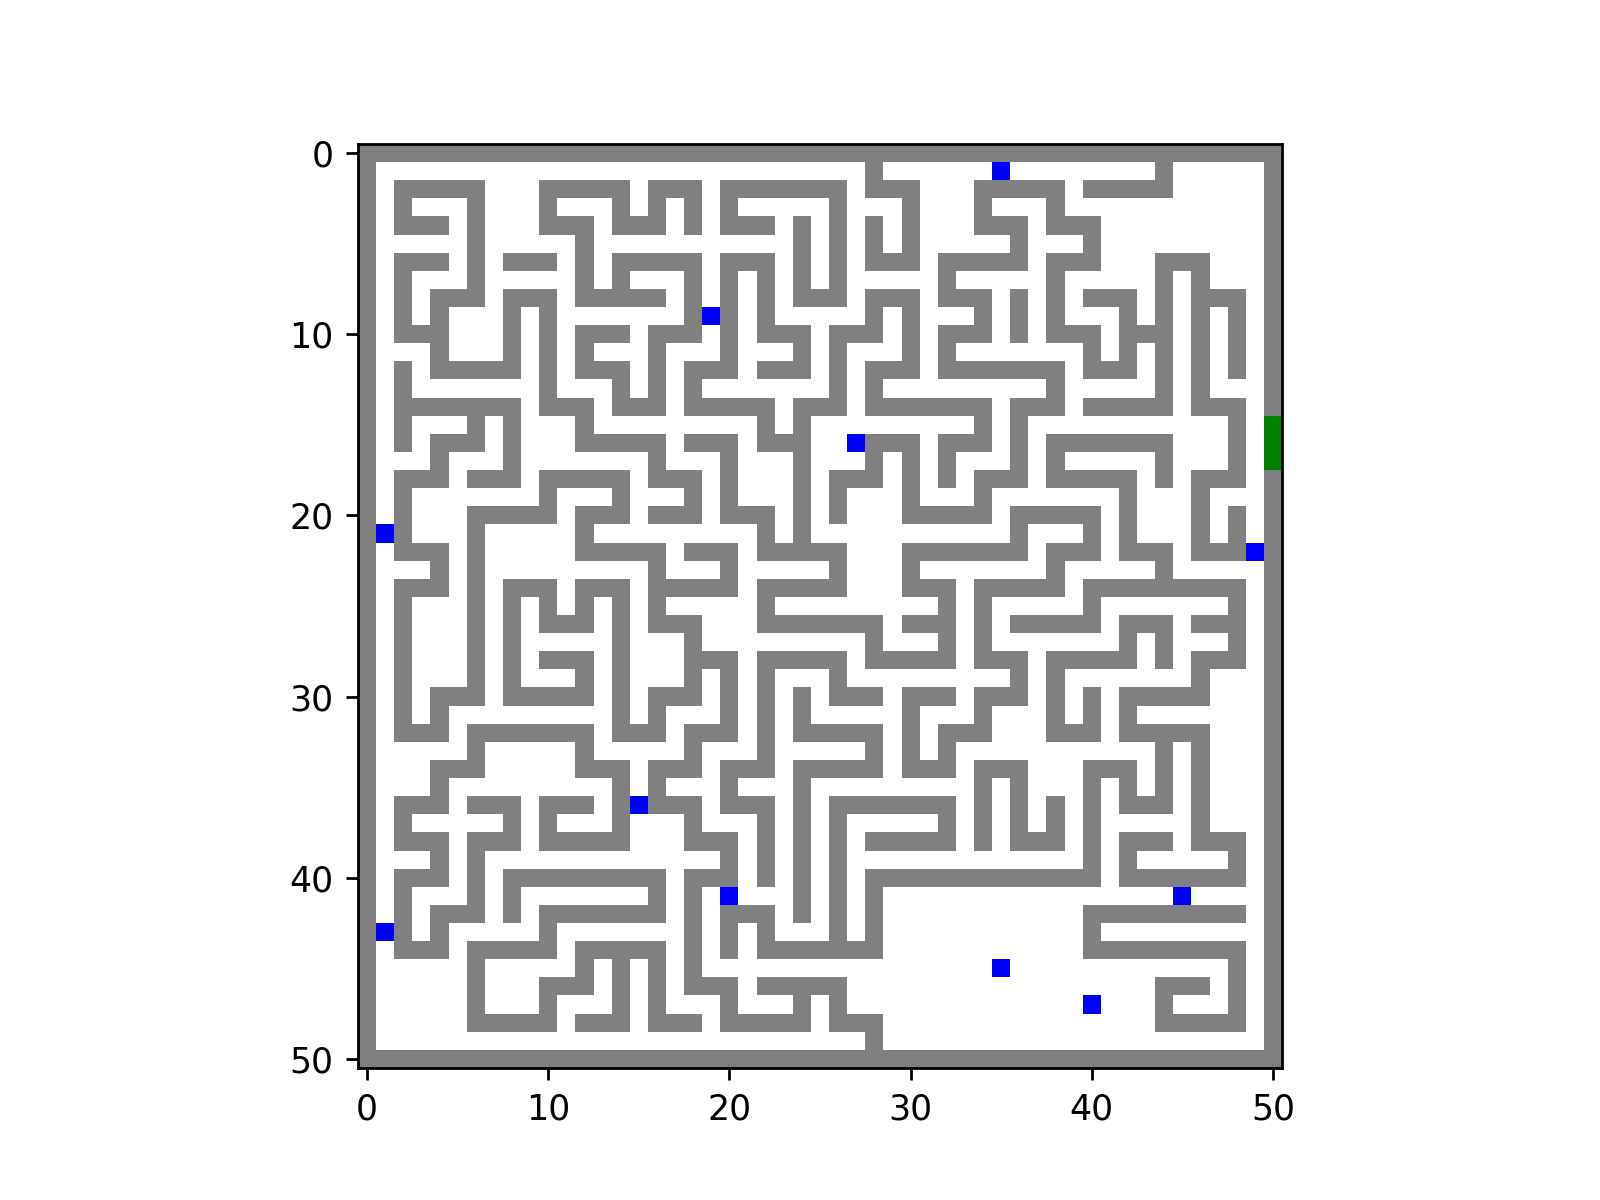

In [43]:
#animate
animation2=animate(maze,0)
animation2.save("maze.gif", writer=writer) 